# Metadata
---

- Created: 2022-10-03
- Last modified: 2022-10-06
- Author: Daniel Kaiser
- Project Identifiers: EMB_ex07R
- Last read and understood by: ???
- Changelog:
    - (2022-10-03) Initialized notebook
    - (2022-10-06) Adjusted to remove custom per-component embedding

# Preface
---

## Experiment protocol

<u>**Experiment ID and project**</u>

EMB_ex07R

<u>**Date designed and version**</u>

- (2022-10-03) v1.0
- (2022-10-06) v2.0


<u>**Date conducted**</u>

- (2022-10-03) v1.0
- (2022-10-06|) v2.0

<u>**Researcher(s)**</u>

Daniel Kaiser

<u>**Description**</u>

**Purpose**

This experiment is designed to explore the accuracy of multiplex reconstruction utilizing Euclidean distance as a proxy for the likelihood of edge-layer placement. Embedding the "remnant" of each layer of a XOR-aggregated duplex, an edge to be classified from the aggregate is predicted to originate from the layer whose remnant embedding yields a smaller distance of the edge endpoints.

**Hypothesis (if applicable)**

The expected outcome of this experiment is an AUROC curve of classification that is an increasing function of PFI, decreasing function of degree homogeneity and edge correlation. Note this matches the high-level qualitative results of the naive Bayes approach used in earlier work. (Project identifier "MEC")

<u>**Data & Code**</u>

**Prerequisite data (if applicable)**

This experiment measures AUROC on a small collection of well-researched dyadic multiplexes. These are the datasets:

- arXiv collaborations (N nodes, 13 layers)
- _C. Elegans_ connectome (279 nodes, 3 layers)
- _Drosophila_ genetic interactions (N nodes, 7 layers)
- London transportation (N nodes, 3 layers)

Additional paramaters include:

- largest_component; flag if remnants should be restricted to largest component (forced with Mercator, optional here to maintain consistency)
- pfi; relative size of multiplex topology observed _a priori_
- metric; probability model selected (see Procedure#5)


**Resultant data**

The resultant data is in the form of a dataframe with columns:
- system -- name of multiplex
- left -- layer id of induced duplex layer one
- right -- layer id of induced duplex layer two
- largest_component -- boolean flag indicating restriction to largest component
- pfi -- relative size of _a priori_ subtensor
- metric -- string indicator of likelihood model used
- Accuracy  -- accuracy of classifications
- AUROC -- area under ROC curve of prediction scores
- dimensions -- embedding dimension
- walk_length  -- length of samples walks
- num_walks -- number of walks per node
- workers -- cores (threads?) per random walk process
- window -- ??
- min_count -- ??
- batch_words -- ??

**Code**

This experiment relies on the custom modules `synthetic.py` & `utils.py` from the `src/` directory, or functions in this document. All code from `src/` is original or only slightly modified MEC code from @Filippo Radicchi.

@Elior Cohen and node2vec's [GitHub repo](https://github.com/eliorc/node2vec) inspired the function `embed_system`.

Some package version updates in Gensim forced some adjustments - thanks to @555wen on [this StackExchange post](https://stackoverflow.com/questions/67413006/typeerror-init-got-an-unexpected-keyword-argument-size) from @yinky for pointing out a parameter name change. In the site-packages for node2vec, `node2vec.py:175` was altered from `if 'size' not in skip_gram_params:` to `if 'vector_size' not in skip_gram_params:`and `node2vec.py:176` was altered from `skip_gram_params['size'] = self.dimensions` to `skip_gram_params['vector_size'] = self.dimensions`.

<u>**Procedure**</u>

The following procedure was conducted to run this experiment and is sufficient to replicate the workflow along with code described in the "Code" section above.
1. Load duplex, $\mathcal{M} = (V, (\alpha, \beta))$
2. Aggregate duplex into a monoplex, $G$, and observe some partial information for each layer $\mathcal{O}_{\alpha}, \mathcal{O}_{\beta}$
3. Create remnants by $\mathcal{R}_{\alpha} = G \setminus \mathcal{O}_{\beta}, \mathcal{R}_{\beta} = G \setminus \mathcal{O}_{\alpha}$
4. Embed $\mathcal{R}_{\alpha}, \mathcal{R}_{\beta}$ separately using node2vec. Call the resultant embedded points $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$.
5. For $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$, classify $(i,j)$ as having originated from layer $\alpha$ ($\beta$) with (one minus) the following probability:
    $$
        P((i,j) \in \alpha) = \frac{
            \frac{1}{d_{\alpha}^{\varepsilon}(i,j)}
        }{
            \frac{1}{d_{\alpha}^{\varepsilon}(i,j)} + \frac{1}{d_{\beta}^{\varepsilon}(i,j)}
        }
    $$
    or
    $$
        P((i,j) \in \alpha) = \frac{
            e^{-d_{\alpha}^{\varepsilon}(i,j)}
        }{
            e^{-d_{\alpha}^{\varepsilon}(i,j)} + e^{-d_{\beta}^{\varepsilon}(i,j)}
        }
    $$

6. Calling the true originating layer of $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$ as $l_{ij}$, measure $\| l - \hat{l} \|$
    - NOTE: Since this is a binary classification problem, we actually elect to use the AUROC of the classification of $(i,j) \mapsto \hat{l}_{ij}$ with ground truth $l_{ij}$. The vector norm is simply a more general form of measuring "difference" in our classifications and the ground truth.

## Theoretical foundations and symbol/prior result guide

Will eventually ill in with background from project "MEC" but this seemed like a waste of time at the current moment

# Experiment
---

## Setup

### Imports

In [1]:
# --- Standard library ---
import sys  # System pathing
import os
import yaml  # Configuration files
from datetime import datetime  # Timestamping data
from copy import deepcopy  # Parameter grid processing
from itertools import product

# --- Scientific ---
import numpy as np  # General computational tools
from sklearn import metrics  # Measuring classifier performance

# --- Network science ---
import networkx as nx  # General network tools
from node2vec import Node2Vec as N2V  # Embedding tools

# --- Project source code ---
sys.path.append("../src/")
from synthetic import *  # Custom synthetic benchmarks
from utils import *

# --- Data handling and visualization ---
import pandas as pd  # Dataframe tools
from tabulate import tabulate  # Pretty printing for dataframes

import seaborn as sns  # Easier plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# --- Miscellaneous ---
from tqdm.auto import tqdm  # Progress bar

### Globals

In [2]:
# --- Other aliases ---
today = datetime.today
accuracy = metrics.accuracy_score
auroc = metrics.roc_auc_score

# --- Visualization ---
rc_dict = {
  "savefig.dpi": 900,  # Saved figure dots-per-inch. 600 is "HD"
  "savefig.facecolor": "white",  # This, combined with transparent setting, keeps saved figs from looking like trash on dark backgrounds 
  "savefig.transparent": False,
  "figure.figsize": (14, 10),  # Default (width, height) of figure
}
plt.rcParams.update(rc_dict)

### Configuration

In [3]:
# - Versioning -
project_id = "EMB_ex07R"
current_version = "v2.0"
researcher = "DK"
date = today().strftime("%Y%m%d")

df_template = f"dataframe_{project_id}{current_version}_{researcher}_{date}"

### Functions

In [4]:
# --- Drivers ---
def embed_system(remnant_G, remnant_H, hyperparams, embedding_method = "node2vec", per_component=True):
    N = remnant_G.number_of_nodes()

    # Apply embedding to remnant graphs
    if embedding_method == "node2vec":
        R_G_embedded_model, R_H_embedded_model = helper_node2vec(remnant_G, remnant_H, hyperparams, per_component=per_component)

        # * NOTE: Need to apply indexing function!
        R_G_vectors = helper_index_vectors_from_model(R_G_embedded_model, range(N), per_component=per_component)
        R_H_vectors = helper_index_vectors_from_model(R_H_embedded_model, range(N), per_component=per_component)
    else:
        raise NotImplementedError("Only Node2Vec prepared rn!")

    # Retrieve vectors from embedding

    return R_G_vectors, R_H_vectors


# --- Helpers ---
def helper_node2vec(remnant_G, remnant_H, hyperparams, per_component=True):
    # Process hyperparameters
    # Embedding parameters
    dimensions, walk_length, num_walks = hyperparams["dimensions"], hyperparams["walk_length"], hyperparams["num_walks"]

    # Computing parameters
    workers, window, min_count, batch_words = hyperparams["workers"], hyperparams["window"], hyperparams["min_count"], hyperparams["batch_words"]


    # Begin embedding (possibly by component)
    if per_component:
        G_ = []
        H_ = []
        for c, component in enumerate(nx.connected_components(remnant_G)):
            component = remnant_G.subgraph(component).copy()

            R_G_embedding = N2V(component, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True)
            R_G_embedding = R_G_embedding.fit(window=window, min_count=min_count, batch_words=batch_words)
            R_G_embedded_model = R_G_embedding.wv
            G_.append(R_G_embedded_model)

        for component in nx.connected_components(remnant_H):
            component = remnant_H.subgraph(component).copy()

            R_H_embedding = N2V(component, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True)
            R_H_embedding = R_H_embedding.fit(window=window, min_count=min_count, batch_words=batch_words)
            R_H_embedded_model = R_H_embedding.wv
            H_.append(R_H_embedded_model)

        return G_, H_

    else:
        # Generate walks
        R_G_embedding = N2V(remnant_G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True)
        R_H_embedding = N2V(remnant_H, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True)

        # Fit word2vec models
        R_G_embedding = R_G_embedding.fit(window=window, min_count=min_count, batch_words=batch_words)
        R_H_embedding = R_H_embedding.fit(window=window, min_count=min_count, batch_words=batch_words)

        # Retrieve embedded models
        R_G_embedded_model = R_G_embedding.wv
        R_H_embedded_model = R_H_embedding.wv

        return R_G_embedded_model, R_H_embedded_model, None

def helper_index_vectors_from_model(embedding_model, node_index_range, per_component=True):
    if per_component:
        vectors = {node_: 0 for node_ in node_index_range}

        for component in embedding_model:
            index_ = component.index_to_key
            vectors_ = component.vectors

            vectors.update({
                int(index_[idx]): vectors_[idx]
                for idx in range(len(index_))
            })

    else:
        index_ = embedding_model.index_to_key
        vectors_ = embedding_model.vectors

        vectors = {int(index_[idx]): vectors_[idx] for idx in node_index_range}

    return vectors

In [5]:
def format_system(params):
    # Process parameters
    pfi = params["pfi"]
    system = params["system"]
    left = params["left"]
    right = params["right"]

    # Form "raw" duplex
    multiplex = read_file(f"../data/input/preprocessed/real/duplex_system={system}.edgelist")

    # Split into layers
    G, H = duplex_network(multiplex, left, right)

    # Observe partial information
    R_G, R_H, testset = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
        edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
        R_G_.add_edges_from(edges_R_G_)
        R_H_.add_edges_from(edges_R_H_)

        testset = {
            edge: gt_
            for edge, gt_ in testset.items()
            if edge in edges_R_H_ | edges_R_H_
        }

    return G, H, R_G, R_H, testset

# def embed_system(R_G, R_H, params):
#     # Process parameters
#     dimensions, walk_length, num_walks = params["dimensions"], params["walk_length"], params["num_walks"]
#     workers, window, min_count, batch_words = params["workers"], params["window"], params["min_count"], params["batch_words"]

#     # Generate walks
#     R_G_emb = N2V(R_G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)
#     R_H_emb = N2V(R_H, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)

#     # Retrieve embedded models
#     G_ = R_G_emb.wv
#     H_ = R_H_emb.wv

#     return G_, H_

def reconstruct_system(testset, G, H, G_, H_, params):
    cls = []
    scores = []
    gt = []

    _dot = lambda x, y: np.exp(-1*np.dot(np.transpose(x), y))

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)

        v_G_i = G_[i]
        v_G_j = G_[j]
        v_H_i = H_[i]
        v_H_j = H_[j]

        if params["metric"] == "logistic":
            d_G = 1 / (1 + _dot(v_G_i, v_G_j))
            d_H = 1 / (1 + _dot(v_H_i, v_H_j))
        else:
            d_G = np.linalg.norm(v_G_i - v_G_j)
            d_H = np.linalg.norm(v_H_i - v_H_j)

            if params["metric"] == "inverse":
                d_G = 1 / (d_G + 1e-16)
                d_H = 1 / (d_H + 1e-16)
            elif params["metric"] == "negexp":
                d_G = np.exp(-d_G)
                d_H = np.exp(-d_H)

        t_G = d_G / (d_G + d_H)
        t_H = 1 - t_G

        scores.append(t_G)

        cls_ = np.random.randint(2)
        if t_G != t_H:
            if np.random.rand() <= t_G:
                cls_ = 1
            else:
                cls_ = 0
        cls.append(cls_)

    return cls, scores, gt

def measure_performance(cls, scores, gt):
    # print(f"Classifications: {cls}\n Scores: {scores}\n GT: {gt}")
    acc = accuracy(gt, cls)
    auc = auroc(gt, scores)

    return acc, auc

### Workflow

In [6]:
def _process_grid():
    # Initialize parameter grid
    grid = []

    # Initialize grid vertex archetype
    params = {}

    # Fill in static parameters (mostly embedding)
    params.update({
        "largest_component": True,
        "dimensions": 10,
        "walk_length": 30,
        "num_walks": 100,
        "workers": 8,
        "window": 10,
        "min_count": 1,
        "batch_words": 4
    })


    # Fill in each vertex with dynamic parameters (networks, mostly)
    for repetition in range(1):
        for system in ["celegans", "london"]: #["arxiv", "celegans", "drosophila", "london"]:
            for metric in ["inverse", "negexp"]:
                for pfi in [0.10, 0.25, 0.50, 0.75, 0.95]:
                    if system == "arxiv":
                        _range = range(1, 3)  # range(1,14)
                    elif system == "celegans":
                        _range = range(1,4)
                    elif system == "drosophila":
                        _range = range(1,8)
                    elif system == "london":
                        _range = range(1,4)

                    for left in _range:
                        for right in range(1,left):
                            params_ = deepcopy(params)

                            params_["system"] = system
                            params_["left"] = left
                            params_["right"] = right

                            params_["metric"] = metric
                            params_["pfi"] = pfi
                            params_["repetition"] = repetition

                            grid.append(params_)

    return grid

def workflow():
    # Process parameter grid
    grid = _process_grid()

    # Prepare results dataframe (dict)
    df_ = {key: [] for key in grid[0].keys()}
    df_["Accuracy"] = []
    df_["AUROC"] = []

    # Run experiment
    for gv in tqdm(grid, desc="Experiment", colour="purple"):
        # Track parameters
        for key, value in gv.items():
            df_[key].append(value)

        # Generate synthetic system and form remnants
        G, H, R_G, R_H, agg = format_system(gv)

        # Apply node2vec
        R_G_vectors, R_H_vectors = embed_system(R_G, R_H, gv, per_component=False)

        # Reconstruct system from embeddings
        cls, scores, gt = reconstruct_system(agg, G, H, R_G_vectors, R_H_vectors, gv)

        # Measure performance
        acc, auc = measure_performance(cls, scores, gt)

        # Update performance measure columns
        df_["Accuracy"].append(acc)
        df_["AUROC"].append(auc)

    # Format dataframe and save
    df = pd.DataFrame(df_)
    df.to_parquet(f"{df_template}.parquet")

    return df

## Computations

In [8]:
df = workflow()

Experiment:   0%|          | 0/60 [00:52<?, ?it/s]


ValueError: too many values to unpack (expected 2)

# Analysis
---

## Post-processing data

## Visualization

### Initial exploration

<Figure size 1400x1000 with 0 Axes>

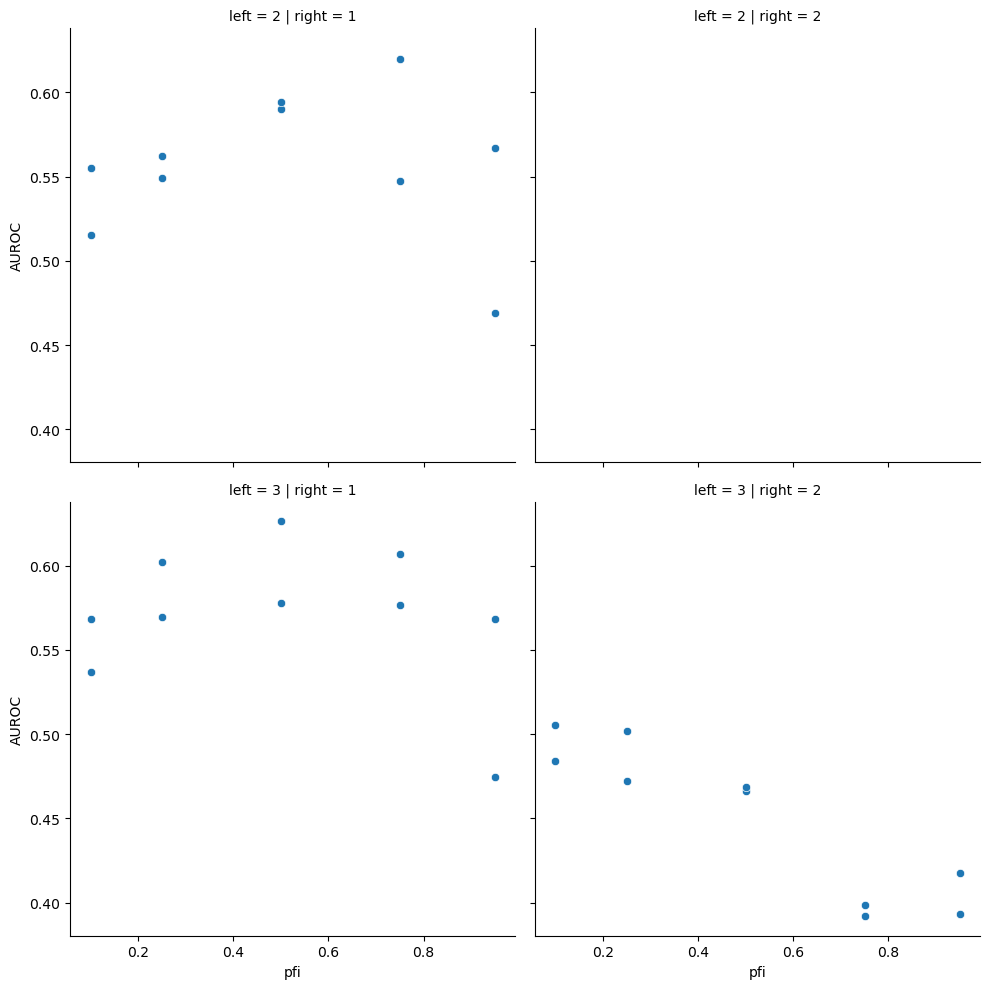

In [ ]:
plt.figure()
sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
    row="left",
    col="right"
)

# plt.savefig("../results/plots/scatter_auroc-pfi_EMB_ex07R_DK_20221003.png")

# Discussion
---

## Observations

## Interpretations

## Follow-up